In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import utils

In [3]:
CODING_SIZE = 100
BATCH_SIZE = 32

In [4]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = utils.load_fashion_mnist_data()
print(f"x_train.shape = {x_train.shape}, x_val.shape = {x_val.shape}")

4423680/4422102 [==============================] - 0s 0us/step
x_train.shape = (55000, 28, 28), x_val.shape = (5000, 28, 28)


In [5]:
utils.reset_session()

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[CODING_SIZE]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME', activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='SAME', activation='tanh'),
])

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='SAME', activation=keras.layers.LeakyReLU(0.2), 
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='SAME', activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False

gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [6]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2.0 - 1.0

dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)\
    .shuffle(1000)\
    .batch(BATCH_SIZE, drop_remainder=True)\
    .prefetch(1)

Epoch 1/5


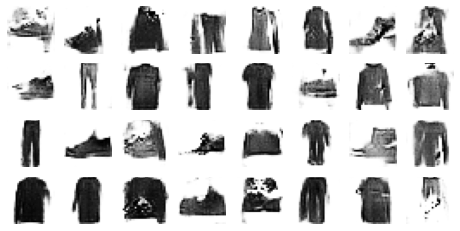

Epoch 2/5


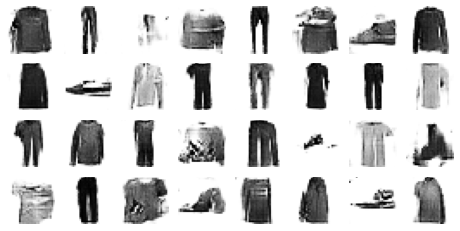

Epoch 3/5


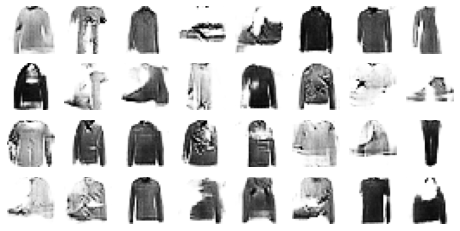

Epoch 4/5


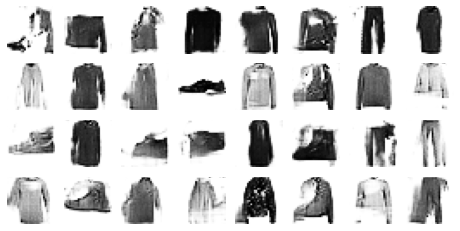

Epoch 5/5


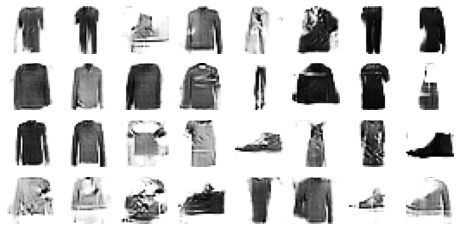

In [10]:
num_epochs = 5

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    for x_batch in dataset:
        # phase 1 - training the discriminator
        noise = tf.random.normal(shape=[BATCH_SIZE, CODING_SIZE])
        generated_images = generator(noise)
        x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
        y1 = tf.constant([[0.]] * BATCH_SIZE + [[1.]] * BATCH_SIZE)
        discriminator.trainable = True
        discriminator.train_on_batch(x_fake_and_real,  y1)

        # phase 2 - training the generator
        noise = tf.random.normal(shape=[BATCH_SIZE, CODING_SIZE])
        y2 = tf.constant([[1.]] * BATCH_SIZE)
        discriminator.trainable = False
        gan.train_on_batch(noise, y2)

    utils.plot_images(np.squeeze(generated_images))